<a href="https://colab.research.google.com/github/fbdsfoa/AtvExtra/blob/master/Exerc%C3%ADcio_Pr%C3%A1tico_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Definir transformações para o dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Achatar a imagem para 784 valores
])

# Baixar o dataset MNIST
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Dividir dataset em treino e teste
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


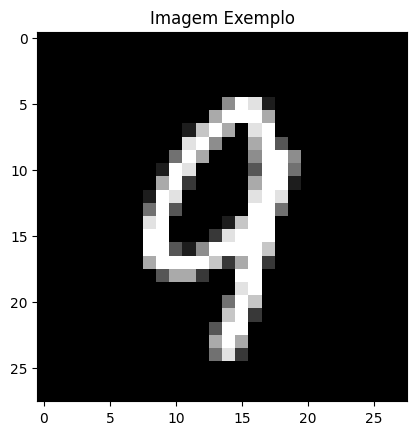

In [30]:
# Criar DataLoader para carregar os dados em batches
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Visualizar uma imagem a partir de um vetor de 784 valores
def show_image_from_vector(data_loader):
    image_vector, label = next(iter(data_loader))
    image_vector = image_vector[0]  # Pegue apenas a primeira imagem do batch
    image_reshaped = image_vector.view(28, 28)  # Reformatar para 28x28
    plt.imshow(image_reshaped, cmap='gray')
    plt.title(f'Imagem Exemplo')
    plt.show()

# Mostrar a imagem antes do treinamento
show_image_from_vector(train_loader)


In [31]:
# Definir um modelo de rede neural totalmente conectado
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)  # Primeira camada (784 -> 1024)
        self.fc2 = nn.Linear(1024, 512)      # Segunda camada (1024 -> 512)
        self.fc3 = nn.Linear(512, 256)       # Terceira camada (512 -> 256)
        self.fc4 = nn.Linear(256, 128)       # Nova camada (256 -> 128)
        self.fc5 = nn.Linear(128, 10)        # Camada de saída (128 -> 10 classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU após a primeira camada
        x = torch.relu(self.fc2(x))  # ReLU após a segunda camada
        x = torch.relu(self.fc3(x))  # ReLU após a terceira camada
        x = torch.relu(self.fc4(x))  # ReLU após a nova camada
        x = self.fc5(x)              # Saída direta (CrossEntropyLoss cuida disso)
        return x

# Instanciar o modelo, definir a função de perda e o otimizador
model = FullyConnectedNN()
criterion = nn.CrossEntropyLoss()
# SGD com momentum
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [32]:
# Função para treinar o modelo
def train_model(model, train_loader, test_loader, criterion, optimizer, max_epochs=20, patience=5):
    train_losses = []
    test_losses = []
    min_train_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()  # Limpar gradientes acumulados
            outputs = model(images)  # Fazer previsões
            loss = criterion(outputs, labels)  # Calcular perda
            loss.backward()  # Retropropagação
            optimizer.step()  # Atualizar os pesos
            running_loss += loss.item()

        # Calcular perda média no treino
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calcular perda no conjunto de teste
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch [{epoch+1}/{max_epochs}], Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        # Verificar se a perda de treino não está diminuindo
        if avg_train_loss < min_train_loss:
            min_train_loss = avg_train_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Parando o treinamento após {epoch+1} épocas devido à estagnação na perda.")
            break

    return train_losses, test_losses


Epoch [1/20], Loss: 0.9843, Test Loss: 0.2624
Epoch [2/20], Loss: 0.1843, Test Loss: 0.1424
Epoch [3/20], Loss: 0.1100, Test Loss: 0.1066
Epoch [4/20], Loss: 0.0769, Test Loss: 0.0945
Epoch [5/20], Loss: 0.0546, Test Loss: 0.0820
Epoch [6/20], Loss: 0.0399, Test Loss: 0.0908
Epoch [7/20], Loss: 0.0307, Test Loss: 0.0919
Epoch [8/20], Loss: 0.0224, Test Loss: 0.0950
Epoch [9/20], Loss: 0.0195, Test Loss: 0.0921
Epoch [10/20], Loss: 0.0149, Test Loss: 0.0973
Epoch [11/20], Loss: 0.0111, Test Loss: 0.0798
Epoch [12/20], Loss: 0.0108, Test Loss: 0.0957
Epoch [13/20], Loss: 0.0057, Test Loss: 0.1256
Epoch [14/20], Loss: 0.0085, Test Loss: 0.1228
Epoch [15/20], Loss: 0.0066, Test Loss: 0.0837
Epoch [16/20], Loss: 0.0016, Test Loss: 0.0800
Epoch [17/20], Loss: 0.0005, Test Loss: 0.0772
Epoch [18/20], Loss: 0.0004, Test Loss: 0.0798
Epoch [19/20], Loss: 0.0002, Test Loss: 0.0801
Epoch [20/20], Loss: 0.0001, Test Loss: 0.0808


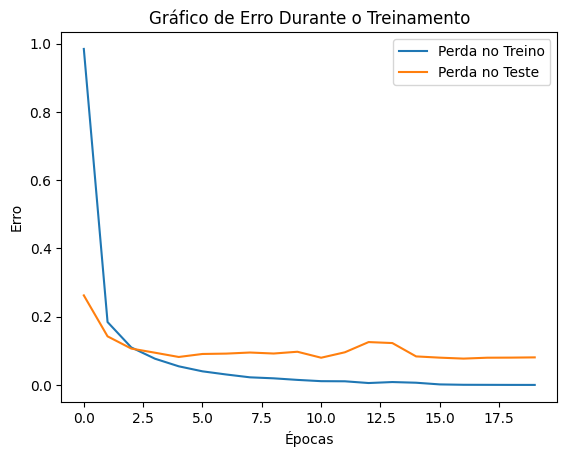

In [33]:
# Função para plotar os gráficos de erro
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label="Perda no Treino")
    plt.plot(test_losses, label="Perda no Teste")
    plt.xlabel("Épocas")
    plt.ylabel("Erro")
    plt.legend()
    plt.title("Gráfico de Erro Durante o Treinamento")
    plt.show()

# Treinar o modelo e plotar os gráficos de erro
train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer)
plot_losses(train_losses, test_losses)


In [34]:
# Função para calcular a precisão (percentual de acertos) do modelo
def calculate_accuracy(model, data_loader):
    model.eval()  # Colocar o modelo em modo de avaliação
    correct = 0
    total = 0
    with torch.no_grad():  # Desligar o cálculo de gradientes para avaliação
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Obter a classe com maior probabilidade
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Contar quantos acertos tivemos
    accuracy = 100 * correct / total
    return accuracy

# Calcular e exibir a precisão no conjunto de treino e de teste
train_accuracy = calculate_accuracy(model, train_loader)
test_accuracy = calculate_accuracy(model, test_loader)

print(f'Acurácia no conjunto de treino: {train_accuracy:.2f}%')
print(f'Acurácia no conjunto de teste: {test_accuracy:.2f}%')

Acurácia no conjunto de treino: 100.00%
Acurácia no conjunto de teste: 98.22%
